In [7]:
%matplotlib inline
import imblearn
import pandas as pd
import seaborn
import sklearn
import mord
import lightning
import statsmodels
import src

# Chosing external features

### Reading DBs, merging

From: https://www.gov.uk/government/statistical-data-sets/monthly-management-information-ofsteds-school-inspections-outcomes we obtain the Ofsted ratings for all UK schools and a other features, such as the number of pupils.

In [268]:
db0 = pd.read_csv('../../Project_resources/External_MI_-_Schools_-_20170131_-_CSV.csv', header=1)\

In [269]:
db0 = db0[['URN','Ofsted phase', 'Total pupils', 'Inspection date',
           'Overall effectiveness', 'Previous full inspection date',
           'Previous full inspection overall effectiveness']]

In [270]:
db0.rename(columns={'Overall effectiveness':'ofsted',
                    'Ofsted phase':'phase',
                    'Total pupils':'totpup',
                    'Inspection date':'insdate',
                    'Previous full inspection date': 'preinsdate',
                    'Previous full inspection overall effectiveness':'preofsted'}, inplace=True)

From: https://www.compare-school-performance.service.gov.uk/download-data we can download several CSV databases with a variety of features for all UK schools.

In [271]:
db1 = pd.read_csv('../../Project_resources/2015-2016/england_spine.csv')

In [272]:
db1.shape

(25188, 34)

First we filter out closed schools:

In [273]:
db1 = db1[db1['ICLOSE']==1] # 2 if school is closed

In [274]:
db1 = db1[['URN', 'SCHNAME', 'TOWN', 'POSTCODE', 'MINORGROUP', 'NFTYPE', 
           'GENDER', 'RELDENOM', 'ADMPOL', 'NEWACFLAG', 'AGEL', 'AGEH']]

In [275]:
db1.rename(columns={'SCHNAME':'name', 'TOWN':'town', 
                    'POSTCODE':'postco', 'MINORGROUP':'type1', 
                    'NFTYPE':'type2', 'GENDER':'gender', 'RELDENOM':'relden', 
                    'ADMPOL':'admpol', 'NEWACFLAG':'acadstat', 
                    'AGEL':'agelow', 'AGEH':'agehi'}, inplace=True)

Types of schools:

In [276]:
db1['type1'].value_counts(dropna=False)

Maintained School     13521
Academy                6366
Independent School     1847
Special School         1215
College                 348
Name: type1, dtype: int64

In [277]:
dball = db0.merge(db1, on='URN', how='inner')

In [278]:
dball.shape

(20551, 18)

In [279]:
dball['type1'].value_counts()

Maintained School    13521
Academy               6277
Special School         753
Name: type1, dtype: int64

We clearly don't have Ofsted ratings for "Independent Schools" and "Colleges".

Well get from a different CSV the number of teachers, pupil to teacher ratio and the teachers salaries.

In [280]:
db2 = pd.read_csv('../../Project_resources/2015-2016/england_swf.csv', decimal=',')

In [281]:
db2 = db2[['URN', 'Total Number of Teachers (Headcount)',
           'Pupil:     Teacher Ratio', 'Mean Gross FTE Salary of All Teachers']]

In [282]:
db2.rename(columns={'Total Number of Teachers (Headcount)':'tottea',
                    'Pupil:     Teacher Ratio':'puptearat', 
                    'Mean Gross FTE Salary of All Teachers':'teasal'}, inplace=True)

In [283]:
dball = dball.merge(db2, on='URN', how='left')

From another CSV we get the total income of the school and expenditure per pupil.

In [284]:
db3 = pd.read_csv('../../Project_resources/2015-2016/england_cfr.csv', decimal=',')

In [285]:
db3 = db3[['URN', 'TOTALEXPENDITURE', 'TOTALINCOME']]

In [286]:
db3.rename(columns={'TOTALEXPENDITURE':'totexpen',
                    'TOTALINCOME':'totinc'}, inplace=True)

In [287]:
dball = dball.merge(db3, on='URN', how='left')

In [288]:
dball.shape

(20551, 23)

In [289]:
dball.to_csv('./data/db_external_features.csv', index=False)

In [3]:
df = pd.read_csv('./data/db_external_features.csv')

The final database is the starting population of UK schools, from which we'll scrape text. The external features are below.

``
URN : Unique school Reference Number
phase : Ofsted phase of education
totpup : The number of pupils on roll (Edubase database, data from the school census 01/16)
insdate : Inspection date
ofsted : Overall effectiveness
preofsted : Previous full inspection overall effectiveness
preinsdate : Previous full inspection date
name :'SCHNAME' - school name
town : 'TOWN' - town
postco : 'POSTCODE' - postcode
type1 : 'MINORGROUP' - big categories
type2 : 'NFTYPE' - minor categories
gendr : 'GENDER' - gender
relden : 'RELDENOM' - Religious denomination 
admpol : 'ADMPOL' - admission policy
acadstat : 'NEWACFLAG' - School academy status
agelow : 'AGEL'- Lowest age of entry
agehi : 'AGEH' - Lowest age of entry
tottea : Total Number of Classroom Teachers and Teachers in the Leadership Group (Headcount)
puptearat : Ratio of pupils to teachers in a school
teasal : Average gross salary of all teachers in a school (pounds)
totexpen : TOTALEXPENDITURE - Total expenditure (pound; per pupil)
totinc : TOTALINCOME -  Sum of grant funding and self generated income (pound; per pupil)
``

### Extracting the relevant features / predictors

In [220]:
df.keys()

Index([u'URN', u'phase', u'totpup', u'insdate', u'ofsted', u'preofsted',
       u'preinsdate', u'name', u'town', u'postco', u'type1', u'type2',
       u'gender', u'relden', u'admpol', u'acadstat', u'agelow', u'agehi',
       u'tottea', u'puptearat', u'teasal', u'totexpen', u'totinc'],
      dtype='object')

Grabbing schools with an existing Ofsted ranking (1,2,3,4)

In [4]:
df[np.isfinite(df['ofsted'])].shape

(19558, 23)

In [5]:
df = df[np.isfinite(df['ofsted'])]

# Checking relevant features / predictors:

Some columns are interesting for statistical analysis and basic correlations but not for building a predictive model (postcode, ages of pupils, religion, gender). This is open to debate.

##### Religion

We could only use ~7k schools. Not very informative probably.

In [5]:
df['relden'].value_counts()[:5]

Does not apply       11464
Church of England     4313
Roman Catholic        1912
None                  1624
Christian               75
Name: relden, dtype: int64

In [6]:
df[df['relden']!='Does not apply'].shape

(8094, 23)

##### Location (city):

In [230]:
df['town'].value_counts().shape

(1171,)

In [231]:
df['town'].value_counts()[:5]

London        1297
Birmingham     390
Manchester     344
Bristol        260
Nottingham     253
Name: town, dtype: int64

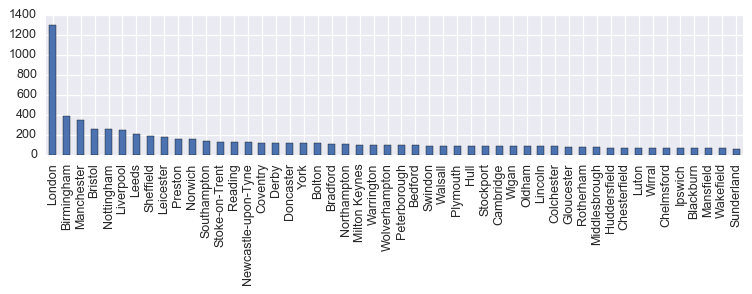

In [327]:
df['town'].value_counts()[:50].plot.bar(figsize=(10,2))

##### School type: 

- academy: run by a governing body, independent from the local authority. They can follow a different curriculum as long as it’s broad, balanced and includes, English, Maths and Science. They can also set their own term times. They still have to follow the same rules for admissions, special educational needs and exclusions as other state schools. Examples: free schools, traditional academies and converter academies.


- mantained school: run by a governing body, follow the national curriculum and are maintained by the local authority. Examples: community schools, foundation schools, voluntary aided schools and voluntary controlled schools.


- special school: A school which is specifically organised to make special educational provision for children and young people with special educational needs who require provision over and above what is available in a mainstream school.

Independent schools are not included in this DB.

In [233]:
df['type1'].value_counts()

Maintained School    13485
Academy               5320
Special School         753
Name: type1, dtype: int64

In [321]:
print df[df['type1']=='Maintained School']['ofsted'].value_counts()
print df[df['type1']=='Academy']['ofsted'].value_counts()
print df[df['type1']=='Special School']['ofsted'].value_counts()

2.0    9975
1.0    2364
3.0    1022
4.0     124
Name: ofsted, dtype: int64
2.0    3130
1.0    1360
3.0     687
4.0     143
Name: ofsted, dtype: int64
2.0    443
1.0    272
3.0     30
4.0      8
Name: ofsted, dtype: int64


In [307]:
df['type2'].value_counts()

Community School                         7454
Academy - Converter Mainstream           3979
Voluntary Aided School                   3203
Voluntary Controlled School              2005
Academy Sponsor Led Mainstream            988
Foundation School                         820
Community Special School                  608
Academy  - Converter Special School       168
Free School - Mainstream                  140
Foundation Special School                  81
Non-Maintained Special School              64
Studio school                              14
University technical college               14
Free School - Special                       9
Academy  - Sponsor Led Special School       8
City Technology College                     3
Name: type2, dtype: int64

##### Gender

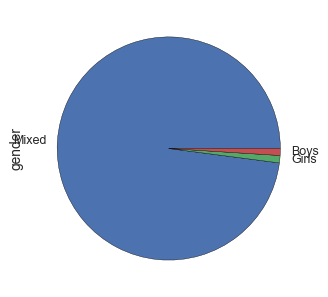

In [328]:
df['gender'].value_counts().plot.pie(figsize=(4,4))

##### Phase of education

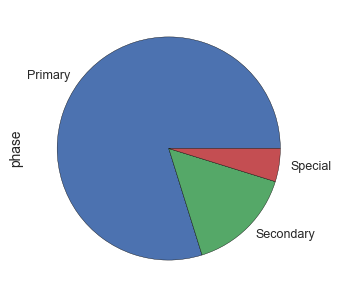

In [329]:
df['phase'].value_counts().plot.pie(figsize=(4,4))

##### Number of pupils

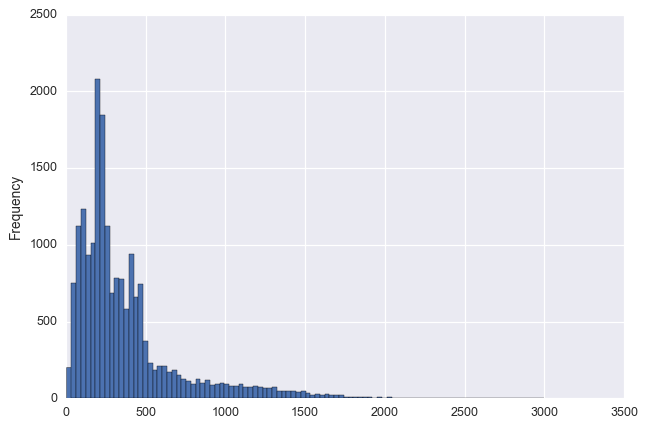

In [240]:
df['totpup'].plot.hist(bins=100)

##### Number of teachers

In [241]:
df['tottea'].dtype

dtype('O')

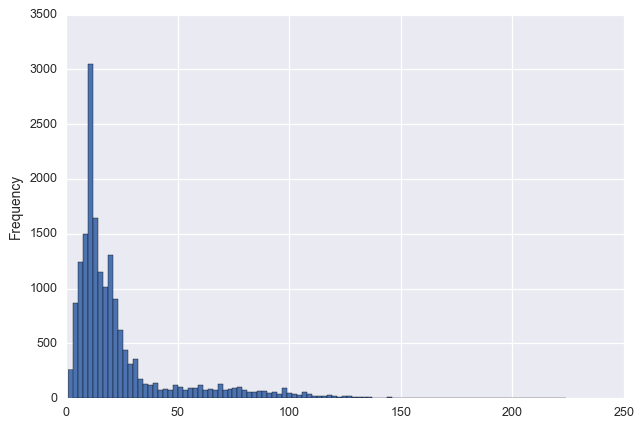

In [245]:
pd.to_numeric(df['tottea'], errors='coerce').plot.hist(bins=100)

In [246]:
test = pd.to_numeric(df['tottea'], errors='coerce')
pd.Series(np.isfinite(test)).value_counts()

True     17836
False     1722
Name: tottea, dtype: int64

##### Pupil-teacher ratio

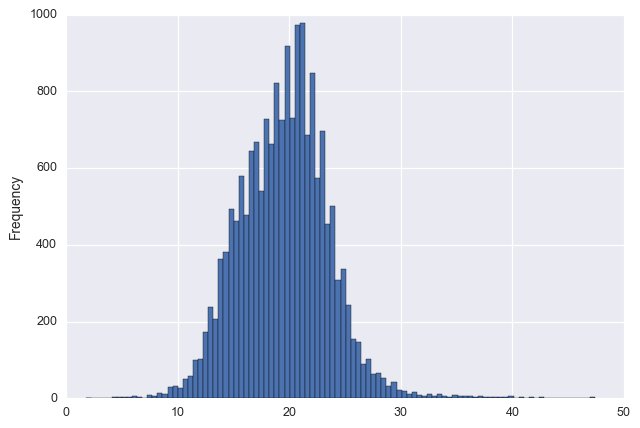

In [247]:
pd.to_numeric(df['puptearat'], errors='coerce').plot.hist(bins=100)

##### Teachers salary

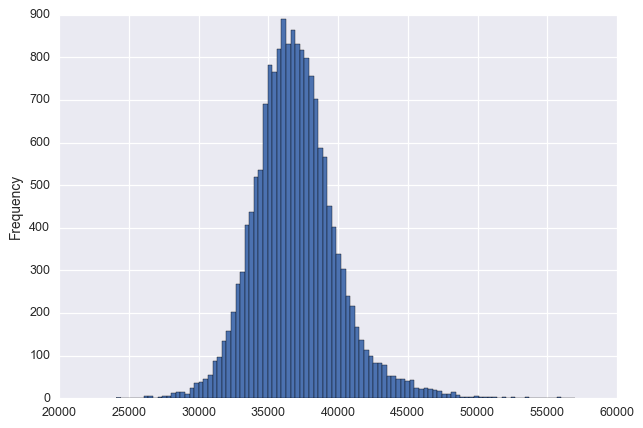

In [248]:
pd.to_numeric(df['teasal'], errors='coerce').plot.hist(bins=100)

##### Total expenditure

In [255]:
pd.Series(np.isfinite(pd.to_numeric(df['totexpen'], errors='coerce'))).value_counts()

True     10647
False     8911
Name: totexpen, dtype: int64

In [259]:
pd.to_numeric(df['totexpen'], errors='coerce').describe()

count    10647.000000
mean         6.268472
std          7.072822
min          2.838000
25%          4.379000
50%          4.950000
75%          5.799500
max        412.927000
Name: totexpen, dtype: float64

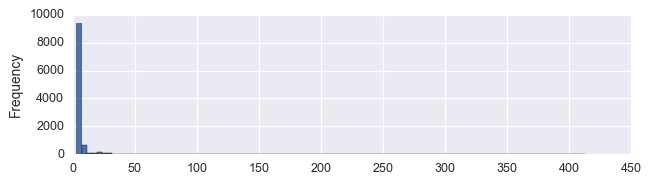

In [330]:
pd.to_numeric(df['totexpen'], errors='coerce').plot.hist(figsize=(8,2), bins=100)

##### Total income

In [261]:
pd.Series(np.isfinite(pd.to_numeric(df['totinc'], errors='coerce'))).value_counts()

True     10648
False     8910
Name: totinc, dtype: int64

In [264]:
pd.to_numeric(df['totinc'], errors='coerce').describe()

count    10648.000000
mean         6.392460
std         10.428208
min          2.000000
25%          4.439000
50%          5.017500
75%          5.850250
max        784.000000
Name: totinc, dtype: float64

##### Previous ofsted score

In [300]:
df['preofsted'].value_counts()

2.0    8169
3.0    7214
1.0    2134
4.0     497
Name: preofsted, dtype: int64

### Building the features matrix

Dealing with categorical features:

In [7]:
# Convert categorical variable into dummy/indicator variables
pd.get_dummies(df['type1'], prefix='is_')[:3]

,is__Academy,is__Maintained School,is__Special School
0,0,1,0
1,0,1,0
2,0,1,0


In [8]:
# LabelEncoder from sklearn
from sklearn.preprocessing import LabelEncoder

labelenc = LabelEncoder()
test = labelenc.fit(df['type1']).transform(df['type1'])
pd.Series(test).value_counts()

1    13485
0     5320
2      753
dtype: int64

Better to use OneHotEncoder or get_dummies from pandas.

http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features

In [113]:
X = pd.get_dummies(df[['URN','type1']], prefix='is_')

In [114]:
X = X.merge(pd.get_dummies(df[['URN','phase']], prefix='is_'), on='URN')

In [115]:
X = X.merge(df[['URN','totpup','tottea']], on='URN')

In [116]:
X['tottea'] = pd.to_numeric(X['tottea'], errors='coerce')

In [117]:
X['totpup'] = pd.to_numeric(X['totpup'], errors='coerce')

In [118]:
sum(pd.isnull(X['totpup'])), sum(pd.isnull(X['tottea']))

(0, 1722)

In [119]:
X['tottea'].describe()

count    17836.000000
mean        24.021473
std         24.709334
min          1.000000
25%         10.000000
50%         15.000000
75%         25.000000
max        224.000000
Name: tottea, dtype: float64

In [120]:
X['tottea'].fillna(X['tottea'].median(), inplace=True)

In [121]:
sum(pd.isnull(X['totpup'])), sum(pd.isnull(X['tottea']))

(0, 0)

In [122]:
X.isnull().values.any()

False

In [123]:
print (sum(pd.to_numeric(df['totexpen'], errors='coerce').isnull()),
       sum(pd.to_numeric(df['totinc'], errors='coerce').isnull()),
       sum(pd.to_numeric(df['teasal'], errors='coerce').isnull()),
       sum(pd.to_numeric(df['preofsted'], errors='coerce').isnull()))

(8911, 8910, 2236, 1544)


In [124]:
X = X.merge(df[['URN','totexpen','totinc','teasal','preofsted']])

In [125]:
X.totinc = pd.to_numeric(X.totinc, errors='coerce')
X.totexpen = pd.to_numeric(X.totexpen, errors='coerce')
X.teasal = pd.to_numeric(X.teasal, errors='coerce')
X.preofsted = pd.to_numeric(X.preofsted, errors='coerce')

In [126]:
X.isnull().values.any()

True

for the previous ofsted we will fill with the mode: 2

In [127]:
pd.to_numeric(df['preofsted'], errors='coerce').mode()

0    2.0
dtype: float64

In [128]:
X.preofsted.fillna(2, inplace=True)

In [129]:
X[X.totinc.isnull()]['totexpen'].min() # totexpen and totinc missing for same URNs

nan

Teachers salary needs filling NAN. Distribution pretty normal, using mean.

In [130]:
sum(X.teasal.isnull()), sum(X[X.teasal.isnull()]['totexpen'].isnull())

(2236, 1439)

In [131]:
X.teasal.fillna(X.teasal.mean(), inplace=True)

In [132]:
X.dropna(axis=0, how='any', inplace=True)

In [133]:
X.isnull().values.any()

False

In [143]:
print X.is__Academy.value_counts()
print X.is__Primary.value_counts()
print X['is__Maintained School'].value_counts()

0    10647
Name: is__Academy, dtype: int64
1    9293
0    1354
Name: is__Primary, dtype: int64
1    10094
0      553
Name: is__Maintained School, dtype: int64


We lost the academies, apparently because of the lack of budget/money related info.

In [144]:
X.drop('is__Academy', axis=1, inplace=True)

In [145]:
X.shape

(10647, 12)

### Getting Y

Setting Y to the Ofsted column

In [146]:
Y = pd.merge(df[['URN','ofsted']], X, on='URN', how='inner').ofsted

In [147]:
Y.value_counts()

2.0    7695
1.0    2057
3.0     793
4.0     102
Name: ofsted, dtype: int64

In [148]:
X.drop('URN', axis=1, inplace=True)

In [151]:
X.shape, Y.shape

((10647, 11), (10647,))

##### Removing outliers from X

In [169]:
X[['totpup', 'tottea', 'totexpen', 'totinc']].describe()

,totpup,tottea,totexpen,totinc
count,10647.000000,10647.000000,10647.000000,10647.000000
mean,326.823049,19.404621,6.268472,6.319424
std,252.477750,17.309493,7.072822,7.207927
min,4.000000,1.000000,2.838000,2.000000
25%,181.000000,10.000000,4.379000,4.439000
50%,249.000000,15.000000,4.950000,5.017000
75%,417.000000,22.000000,5.799500,5.850000
max,2260.000000,153.000000,412.927000,456.317000


In [177]:
X.totinc.quantile(.99), X.totexpen.quantile(.99)

(29.885139999999964, 29.988039999999785)

In [186]:
X[X.totinc>456]

,is__Maintained School,is__Special School,is__Primary,is__Secondary,is__Special,totpup,tottea,totexpen,totinc,teasal,preofsted
375,0,1,0,0,1,7.0,15.0,412.927,456.317,36953.96415,1.0


In [189]:
X.drop(375, 0, inplace=True); Y.drop(375, inplace=True)

In [190]:
X[X.totexpen>400]

,is__Maintained School,is__Special School,is__Primary,is__Secondary,is__Special,totpup,tottea,totexpen,totinc,teasal,preofsted


1 outlier school!

In [196]:
X.to_csv('./data/X_10646x11.csv', index=False)
Y.to_csv('./data/Y_10646x11.csv', index=False)

In [3]:
X = pd.read_csv('./data/X_10646x11.csv')
Y = pd.read_csv('./data/Y_10646x11.csv', header=None, squeeze=True)

# ML: Predictive models (ordinal regression, classification)

In [4]:
X[:3]

,is__Maintained School,is__Special School,is__Primary,is__Secondary,is__Special,totpup,tottea,totexpen,totinc,teasal,preofsted
0,1,0,1,0,0,250.0,22.0,8.288,8.775,43148.0,1.0
1,1,0,1,0,0,417.0,25.0,6.798,6.687,42507.0,2.0
2,1,0,1,0,0,456.0,29.0,6.294,6.576,43168.0,2.0


Approaches in the package imblearn:

``
Under-sampling
    Random majority under-sampling with replacement
    Extraction of majority-minority Tomek links
    Under-sampling with Cluster Centroids
    NearMiss-(1 & 2 & 3)
    Condensend Nearest Neighbour
    One-Sided Selection
    Neighboorhood Cleaning Rule
    Edited Nearest Neighbours 
    Instance Hardness Threshold
    Repeated Edited Nearest Neighbours
    AllKNN 
Over-sampling
    Random minority over-sampling with replacement
    SMOTE - Synthetic Minority Over-sampling Technique 
    bSMOTE(1 & 2) - Borderline SMOTE of types 1 and 2 
    SVM SMOTE - Support Vectors SMOTE 
    ADASYN - Adaptive synthetic sampling approach for imbalanced learning 
Over-sampling followed by under-sampling
    SMOTE + Tomek links
    SMOTE + ENN 
Ensemble sampling
    EasyEnsemble 
    BalanceCascade 
``

Most naive approach, random undersampling of the majority classes.

In [10]:
X_train, X_test, y_train, y_test = src.resample_classes(X, Y, 'over1', None, test_size=0.3, verbose=True)


			1	2	3	4
Counts in y_init:	2057	7694	793	102 
Counts in y_resamp:	7694	7694	7694	7694 
Counts in y_train:	5398	5365	5391	5389 
Counts in y_test:	2303	2305	2329	2296 
X_train: (21543, 11) , X_test: (9233, 11)


##### Ordinal Logistic Regression

Using package ``mord``.

In [11]:
import mord

In [204]:
clasif1 = mord.LogisticAT(alpha=1e-5, verbose=1, max_iter=1e6)
#clasif1 = mord.LogisticIT(alpha=1e0, verbose=1, max_iter=10000)
#clasif1 = mord.OrdinalRidge(alpha=1e-5, fit_intercept=True, normalize=False, copy_X=True, 
#                            max_iter=None, tol=0.001, solver='auto', random_state=0)
# clasif1 = mord.LAD(epsilon=0.0, tol=0.0001, C=1.0, loss='l1', fit_intercept=True, 
#                    intercept_scaling=1.0, dual=True, verbose=0, random_state=0, max_iter=10000)

clasif1.fit(X_train, y_train.astype(int))

clasif1.coef_, clasif1.theta_

(array([  0.00000000e+00,   1.03143154e+00,  -6.15448829e-01,
         -2.87554789e-01,   1.31898632e+00,  -6.15448829e-01,
          1.55557955e-04,  -4.68134631e-03,   7.29311895e-01,
         -6.51658597e-01,  -7.70746545e-05,   1.03798011e+00]),
 array([-0.41598272,  0.82703578,  2.1473921 ]))

In [205]:
y_pred1 = clasif1.predict(X_test)
print imbmet.classification_report_imbalanced(y_test, y_pred1)

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.64      0.22      0.96      0.32      0.71      0.49      2087
        2.0       0.25      0.43      0.59      0.31      0.43      0.18      1992
        3.0       0.31      0.51      0.64      0.39      0.50      0.24      2046
        4.0       0.47      0.18      0.93      0.26      0.60      0.35      2194

avg / total       0.42      0.33      0.78      0.32      0.56      0.32      8319



##### PRank

http://contrib.scikit-learn.org/lightning/intro.html

PRank: a variant of the perceptron algorithm that found multiple parallel hyperplanes separating the various ranks; its output is a weight vector w and a sorted vector of K−1 thresholds θ, as in the ordered logit/probit models. The prediction rule for this model is to output the smallest rank k such that wx < θk.

Kernelized online algorithm for learning an ordinal regression model.
- http://contrib.scikit-learn.org/lightning/generated/lightning.ranking.KernelPRank.html
- https://papers.nips.cc/paper/2023-pranking-with-ranking.pdf


In [12]:
from lightning import ranking

In [264]:
#clasif2 = ranking.PRank(n_iter=1000, shuffle=True, random_state=0)
clasif2 = ranking.KernelPRank(n_iter=200, shuffle=True, random_state=None, 
                              kernel='rbf', gamma=1e2, degree=3, coef0=1)

clasif2.fit(X_train, y_train.astype(int))

KernelPRank(coef0=1, degree=3, gamma=100.0, kernel='rbf', kernel_params=None,
      n_iter=200, random_state=None, shuffle=True)

In [265]:
y_pred2 = clasif2.predict(X_test)
print imbmet.classification_report_imbalanced(y_test, y_pred2)

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.00      0.00      1.00      0.00      0.00      0.00        33
        2.0       0.61      0.86      0.78      0.71      0.76      0.55        35
        3.0       0.38      0.90      0.50      0.53      0.60      0.34        31
        4.0       0.00      0.00      1.00      0.00      0.00      0.00        24

avg / total       0.27      0.47      0.81      0.34      0.37      0.24       123



In [228]:
y_all_pred2 = clasif2.predict(X)
print imbmet.classification_report_imbalanced(Y, y_all_pred2)

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.99      0.71      1.00      0.82      0.96      0.93      2057
        2.0       0.93      0.85      0.85      0.89      0.80      0.65      7695
        3.0       0.36      0.98      0.86      0.53      0.60      0.34       793
        4.0       0.96      0.70      1.00      0.81      0.98      0.95       102

avg / total       0.90      0.83      0.88      0.85      0.82      0.69     10647



##### Random Forest

Random Forest from Scikit-learn:

In [14]:
from sklearn.ensemble import RandomForestClassifier as RFC
from imblearn import metrics as imbmet

In [585]:
clasif3 = RFC(n_estimators=1000, criterion='gini', max_depth=None, min_samples_split=2, 
              min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
              max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=True, 
              n_jobs=2, random_state=None, verbose=0, warm_start=False, class_weight=None)

clasif3.fit(X_train, y_train.astype(int))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=2, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [586]:
y_pred3 = clasif3.predict(X_test)
print imbmet.classification_report_imbalanced(y_test, y_pred3)

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.84      0.96      0.94      0.90      0.91      0.82      2301
        2.0       0.95      0.78      0.99      0.86      0.94      0.89      2333
        3.0       0.96      1.00      0.99      0.98      0.98      0.96      2336
        4.0       1.00      1.00      1.00      1.00      1.00      1.00      2264

avg / total       0.94      0.93      0.98      0.93      0.96      0.92      9234



In [245]:
y_all_pred3 = clasif3.predict(X)
print imbmet.classification_report_imbalanced(Y, y_all_pred3)

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.83      0.98      0.95      0.90      0.91      0.82      2057
        2.0       0.99      0.94      0.99      0.96      0.92      0.86      7695
        3.0       0.90      1.00      0.99      0.95      0.95      0.89       793
        4.0       0.98      1.00      1.00      0.99      0.99      0.98       102

avg / total       0.96      0.95      0.98      0.95      0.92      0.86     10647



In [142]:
clasif3.predict_proba(X)

array([[ 0.885,  0.073,  0.035,  0.007],
       [ 0.109,  0.85 ,  0.041,  0.   ],
       [ 0.075,  0.905,  0.02 ,  0.   ],
       ..., 
       [ 0.138,  0.85 ,  0.01 ,  0.002],
       [ 0.174,  0.785,  0.041,  0.   ],
       [ 0.809,  0.169,  0.017,  0.005]])

Trying RF to split without balancing the classes: 

In [182]:
X_train_unb, X_test_unb, y_train_unb, y_test_unb = train_test_split(X, Y, 
                                                                    test_size=0.3, 
                                                                    random_state=None)

clasif4 = RFC(n_estimators=1000, criterion='gini', max_depth=None, min_samples_split=2, 
              min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
              max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=True, 
              n_jobs=2, random_state=None, verbose=0, warm_start=False, 
              class_weight='balanced')

# 1.0    2057
# 2.0    7695
# 3.0     793
# 4.0     102

clasif4.fit(X_train_unb, y_train_unb)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=2,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [183]:
y_all_pred4 = clasif4.predict(X_test_unb)
print imbmet.classification_report_imbalanced(y_test_unb, y_all_pred4)

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.48      0.14      0.96      0.22      0.63      0.38       644
        2.0       0.73      0.96      0.11      0.83      0.60      0.37      2292
        3.0       0.20      0.01      1.00      0.02      0.43      0.17       231
        4.0       0.00      0.00      1.00      0.00      0.00      0.00        28

avg / total       0.64      0.72      0.35      0.64      0.59      0.36      3195



##### Grid of calls for combining the sampling techniques and classfiers

In [554]:
%%time
res = []
for resamp in ['und1', 'und2', 'und3', 'over1', 'over2', 'over3', 'comb1']:
    X_train, X_test, y_train, y_test = resample_classes(X, Y, resamp, None, test_size=0.3, 
                                                        verbose=True)
    for classif in ['or1','or2','or3','or4','prank','kprank','rfc','svc']:
        print '__________________________________________________________________________'
        res.append(run_classification(X_train, X_test, y_train, y_test, classif, None, 
                                      verbose=True))

Under-sampling the majority class(es) by randomly picking samples without replacement
			1	2	3	4
Counts in y_init:	2057	7695	793	102 
Counts in y_resamp:	102	102	102	102 
Counts in y_train:	72	77	67	69 
Counts in y_test:	35	30	33	25 
X_train: (285, 12) , X_test: (123, 12)
__________________________________________________________________________
LogisticAT(alpha=1.0, max_iter=100000.0, verbose=1)

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.62      0.17      0.97      0.26      0.70      0.48        30
        2.0       0.29      0.43      0.58      0.34      0.46      0.20        35
        3.0       0.22      0.33      0.57      0.27      0.39      0.15        33
        4.0       0.08      0.04      0.88      0.05      0.25      0.06        25

avg / total       0.31      0.26      0.73      0.24      0.46      0.22       123


F1=0.24, Recall=0.26, Cohen Kappa=-0.01
_________________________________________________________

/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


			1	2	3	4
Counts in y_init:	2057	7695	793	102 
Counts in y_resamp:	7618	7695	7618	7618 
Counts in y_train:	5382	5348	5328	5326 
Counts in y_test:	2290	2292	2270	2313 
X_train: (21384, 12) , X_test: (9165, 12)
__________________________________________________________________________
LogisticAT(alpha=1.0, max_iter=100000.0, verbose=1)

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.63      0.21      0.96      0.31      0.70      0.48      2292
        2.0       0.24      0.41      0.57      0.31      0.42      0.17      2313
        3.0       0.32      0.51      0.64      0.40      0.51      0.25      2290
        4.0       0.45      0.17      0.93      0.25      0.59      0.34      2270

avg / total       0.41      0.33      0.77      0.32      0.56      0.31      9165


F1=0.32, Recall=0.33, Cohen Kappa=0.10
__________________________________________________________________________
LogisticIT(alpha=1.0, max_iter=100000.0, verbo

/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


			1	2	3	4
Counts in y_init:	2057	7695	793	102 
Counts in y_resamp:	7519	7695	7280	7170 
Counts in y_train:	5060	5339	5388	4977 
Counts in y_test:	2307	2180	2193	2220 
X_train: (20764, 12) , X_test: (8900, 12)
__________________________________________________________________________
LogisticAT(alpha=1.0, max_iter=100000.0, verbose=1)

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.59      0.18      0.96      0.28      0.68      0.46      2180
        2.0       0.28      0.50      0.55      0.36      0.46      0.20      2307
        3.0       0.31      0.48      0.64      0.38      0.49      0.23      2220
        4.0       0.51      0.15      0.95      0.24      0.63      0.38      2193

avg / total       0.42      0.33      0.77      0.31      0.56      0.32      8900


F1=0.31, Recall=0.33, Cohen Kappa=0.11
__________________________________________________________________________
LogisticIT(alpha=1.0, max_iter=100000.0, verbo

/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type 

			1	2	3	4
Counts in y_init:	2057	7695	793	102 
Counts in y_resamp:	6973	6775	6867	7210 
Counts in y_train:	5035	4748	4898	4796 
Counts in y_test:	2075	2027	2071	2175 
X_train: (19477, 12) , X_test: (8348, 12)
__________________________________________________________________________
LogisticAT(alpha=1.0, max_iter=100000.0, verbose=1)

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.65      0.22      0.96      0.33      0.72      0.51      2075
        2.0       0.24      0.41      0.58      0.30      0.42      0.17      2027
        3.0       0.32      0.51      0.64      0.39      0.50      0.24      2071
        4.0       0.47      0.19      0.92      0.27      0.60      0.35      2175

avg / total       0.42      0.33      0.78      0.32      0.56      0.32      8348


F1=0.32, Recall=0.33, Cohen Kappa=0.11
__________________________________________________________________________
LogisticIT(alpha=1.0, max_iter=100000.0, verbo

In [580]:
namecol = ('f1','recall','ck')
nameind = ('or1','or2','or3','or4','prank','kprank','rfc','svc')
und1 = pd.DataFrame(np.array(res[0:8]), columns=namecol, index=nameind)
und2 = pd.DataFrame(np.array(res[8:16]), columns=namecol, index=nameind)
und3 = pd.DataFrame(np.array(res[16:24]), columns=namecol, index=nameind)
und4 = pd.DataFrame(np.array(res[24:32]), columns=namecol, index=nameind)
und5 = pd.DataFrame(np.array(res[32:40]), columns=namecol, index=nameind)
und6 = pd.DataFrame(np.array(res[40:48]), columns=namecol, index=nameind)
und7 = pd.DataFrame(np.array(res[48:56]), columns=namecol, index=nameind)

(0, 1)

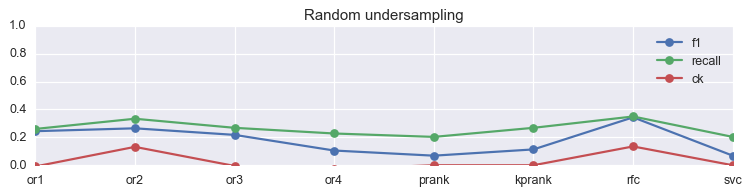

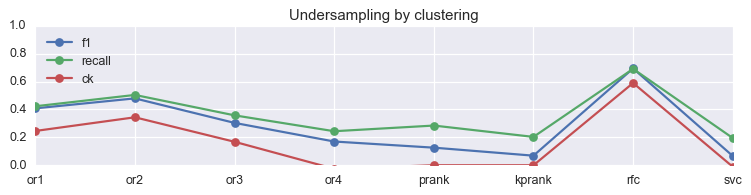

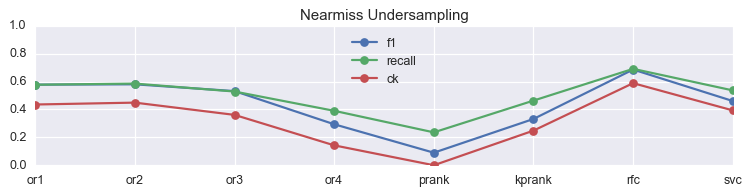

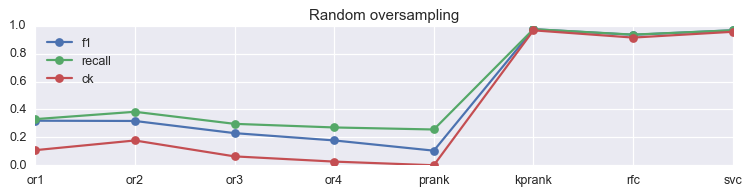

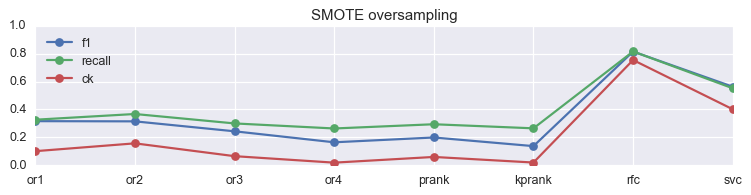

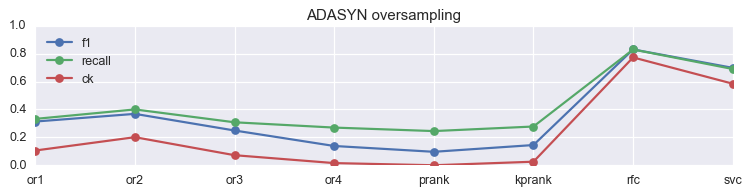

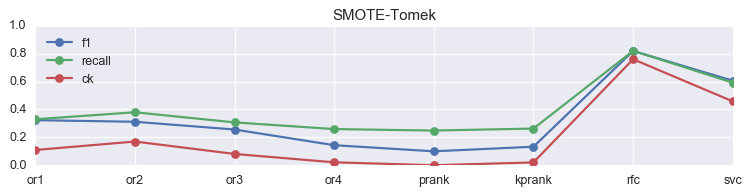

In [583]:
und1.plot(figsize=(10,2), marker='o', title='Random undersampling'); ylim(0,1)
und2.plot(figsize=(10,2), marker='o', title='Undersampling by clustering'); ylim(0,1)
und3.plot(figsize=(10,2), marker='o', title='Nearmiss Undersampling'); ylim(0,1)
und4.plot(figsize=(10,2), marker='o', title='Random oversampling'); ylim(0,1)
und5.plot(figsize=(10,2), marker='o', title='SMOTE oversampling'); ylim(0,1)
und6.plot(figsize=(10,2), marker='o', title='ADASYN oversampling'); ylim(0,1)
und7.plot(figsize=(10,2), marker='o', title='SMOTE-Tomek'); ylim(0,1)

**Remarks:**
- OR not working with mord. No other algo for python doing ordinal regression
- random Under-sampling gives poors metrics for any classifier
- Random naive Over-sampling most probably causes overfitting (high metrics)
- RFC works pretty well out of box

**To try**
- Parameter tuning + CV with promising models
- ensemble classifier with 2or 3 most promising models

http://stats.stackexchange.com/questions/95797/how-to-split-the-dataset-for-cross-validation-learning-curve-and-final-evaluat

# Clustering

http://scikit-learn.org/stable/modules/clustering.html

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

In [16]:
src.run_clustering(X, Y, how='kmeans', n_clusters=4, npcs=None, stand=False)

			1	2	3	4
Counts in labels:	2057	7694	793	102 
Counts in clusters:	2586	4914	599	2547 

Confusion matrix:
[[ 582  962  150  363]
 [1795 3554  412 1933]
 [ 181  350   34  228]
 [  28   48    3   23]] 

Homogeneity=0.005 | Completeness=0.003 | V measure0.004

             precision    recall  f1-score   support

        1.0       0.23      0.28      0.25      2057
        2.0       0.72      0.46      0.56      7694
        3.0       0.06      0.04      0.05       793
        4.0       0.01      0.23      0.02       102

avg / total       0.57      0.39      0.46     10646



KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=20, n_jobs=2, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [17]:
src.run_clustering(X, Y, how='kmeans', n_clusters=4, npcs=None, stand=True)

			1	2	3	4
Counts in labels:	2057	7694	793	102 
Counts in clusters:	3939	554	802	5351 

Confusion matrix:
[[ 155  204  122 1576]
 [3405  326  501 3462]
 [ 342   21  149  281]
 [  37    3   30   32]] 

Homogeneity=0.084 | Completeness=0.062 | V measure0.072

             precision    recall  f1-score   support

        1.0       0.04      0.08      0.05      2057
        2.0       0.59      0.04      0.08      7694
        3.0       0.19      0.19      0.19       793
        4.0       0.01      0.31      0.01       102

avg / total       0.45      0.06      0.08     10646



KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=20, n_jobs=2, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

PCs explained variance ratios:
[ 0.44756519  0.28687671]

			1	2	3	4
Counts in labels:	2057	7694	793	102 
Counts in clusters:	3137	555	793	6161 

Confusion matrix:
[[ 594  204  122 1137]
 [2304  327  493 4570]
 [ 217   21  148  407]
 [  22    3   30   47]] 

Homogeneity=0.016 | Completeness=0.012 | V measure0.014

             precision    recall  f1-score   support

        1.0       0.19      0.29      0.23      2057
        2.0       0.59      0.04      0.08      7694
        3.0       0.19      0.19      0.19       793
        4.0       0.01      0.46      0.02       102

avg / total       0.48      0.10      0.12     10646



KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=20, n_jobs=2, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

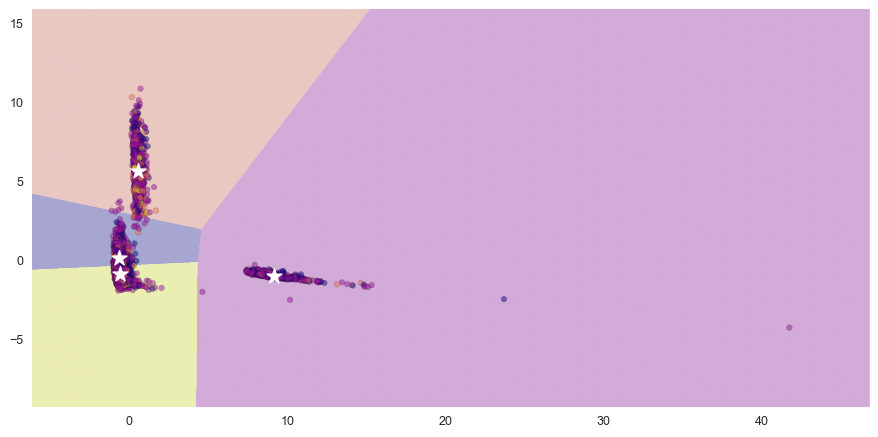

In [19]:
src.run_clustering(X, Y, how='kmeans', n_clusters=4, npcs=2, stand=True)

In [37]:
X_res, Y_res = src.resample_classes(X, Y, 'und1', None, split=False, verbose=True)

Under-sampling the majority class(es) by randomly picking samples without replacement
			1	2	3	4
Counts in y_init:	2057	7694	793	102 
Counts in y_resamp:	102	102	102	102 


PCs explained variance ratios:
[ 0.41821639  0.30995608] 

			1	2	3	4
Counts in labels:	102	102	102	102 
Counts in clusters:	318	68	21	1 

Confusion matrix:
[[82  9 10  1]
 [91  7  4  0]
 [76 22  4  0]
 [69 30  3  0]] 

Homogeneity=0.029 | Completeness=0.061 | V measure0.039

             precision    recall  f1-score   support

        1.0       0.26      0.80      0.39       102
        2.0       0.10      0.07      0.08       102
        3.0       0.19      0.04      0.07       102
        4.0       0.00      0.00      0.00       102

avg / total       0.14      0.23      0.13       408



KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=20, n_jobs=2, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

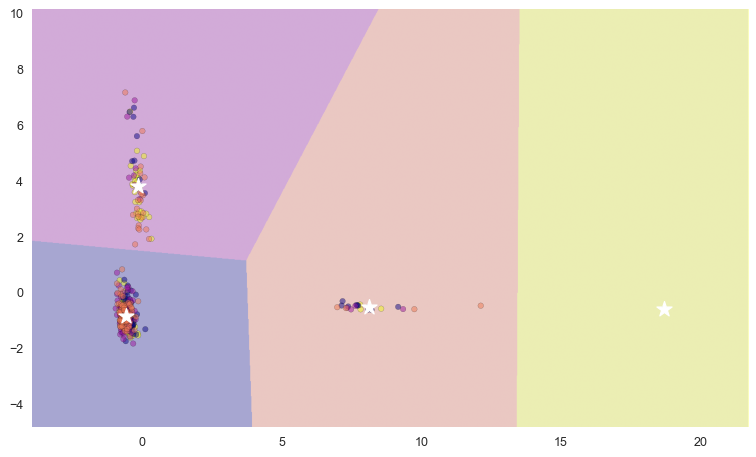

In [34]:
src.run_clustering(X_res, Y_res, how='kmeans', n_clusters=4, npcs=2, stand=True, n_iter=100,
                   boundary=True)

In [206]:
src.run_clustering(X_res, Y_res, how='agglom', n_clusters=4, npcs=None, stand=True, n_iter=100,
                   boundary=True)

			1	2	3	4
Counts in labels:	102	102	102	102 
Counts in clusters:	207	20	64	117 

Confusion matrix:
[[75 13  8  6]
 [54  4 10 34]
 [42  0 16 44]
 [36  3 30 33]] 

Homogeneity=0.079 | Completeness=0.096 | V measure0.086

             precision    recall  f1-score   support

        1.0       0.36      0.74      0.49       102
        2.0       0.20      0.04      0.07       102
        3.0       0.25      0.16      0.19       102
        4.0       0.28      0.32      0.30       102

avg / total       0.27      0.31      0.26       408



In [38]:
src.run_clustering(X_res, Y_res, how='spect', n_clusters=4, npcs=None, stand=True, n_iter=100,
                   boundary=True)

			1	2	3	4
Counts in labels:	102	102	102	102 
Counts in clusters:	162	189	13	44 

Confusion matrix:
[[35 54  8  5]
 [41 54  3  4]
 [40 49  1 12]
 [46 32  1 23]] 

Homogeneity=0.034 | Completeness=0.044 | V measure0.038

             precision    recall  f1-score   support

        1.0       0.22      0.34      0.27       102
        2.0       0.29      0.53      0.37       102
        3.0       0.08      0.01      0.02       102
        4.0       0.52      0.23      0.32       102

avg / total       0.28      0.28      0.24       408



SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1.0, kernel_params=None,
          n_clusters=4, n_init=10, n_jobs=1, n_neighbors=10,
          random_state=None)

In [39]:
src.run_clustering(X_res, Y_res, how='birch', n_clusters=4, npcs=None, stand=True, n_iter=100,
                   boundary=True)

			1	2	3	4
Counts in labels:	102	102	102	102 
Counts in clusters:	195	131	61	21 

Confusion matrix:
[[81  5  6 10]
 [49 42  7  4]
 [34 46 18  4]
 [31 38 30  3]] 

Homogeneity=0.092 | Completeness=0.111 | V measure0.101

             precision    recall  f1-score   support

        1.0       0.42      0.79      0.55       102
        2.0       0.32      0.41      0.36       102
        3.0       0.30      0.18      0.22       102
        4.0       0.14      0.03      0.05       102

avg / total       0.29      0.35      0.29       408



Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=4,
   threshold=0.1)

**Remarks:**
- Higher f1 score when using the 11 features. More variance in the result compared to the case where PCA is used.
- The f1 is in general bad for the minority class.
- Oversamplig helps the minority score. In general each sampling approach changes the configuration of the centroids and decision boundaries (With npcs2).
- In the npcs2 space the classes don't form clusters.
- No matter the algorithm the average recall or f1 scores remain <0.35.
- Removing the outlying school did not improve the clustering.
- The clustering assigned labels doesn't necessary match the correct classes (in the order the data is labeled) http://stamfordresearch.com/k-means-clustering-in-python/

In [20]:
X_train, X_test, y_train, y_test = src.resample_classes(X, Y, 'over1', None, split=True, verbose=True)


			1	2	3	4
Counts in y_init:	2057	7694	793	102 
Counts in y_resamp:	7694	7694	7694	7694 
Counts in y_train:	5349	5393	5426	5375 
Counts in y_test:	2301	2345	2268	2319 
X_train: (21543, 11) , X_test: (9233, 11)


In [21]:
src.run_classification(X_train, X_test, y_train, y_test, how='rfc', random_state=0, n_jobs=2,
                       stand=False, verbose=True, full_output=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=2, oob_score=True, random_state=0,
            verbose=0, warm_start=False)

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.86      0.96      0.95      0.91      0.92      0.84      2319
        2.0       0.95      0.81      0.99      0.87      0.95      0.90      2268
        3.0       0.97      1.00      0.99      0.98      0.98      0.96      2345
        4.0       1.00      1.00      1.00      1.00      1.00      1.00      2301

avg / total       0.94      0.94      0.98      0.94      0.96      0.92      9233

Feature importances:
[ 0.00098127  0.00090006  0.00422935  0.01090353  0.00088365  0.19220111
  0.13144926  0.1993209

(0.94117136949367597, 0.94216397703888222, 0.92285742073441335)

In [46]:
X.keys()

Index([u'is__Maintained School', u'is__Special School', u'is__Primary',
       u'is__Secondary', u'is__Special', u'totpup', u'tottea', u'totexpen',
       u'totinc', u'teasal', u'preofsted'],
      dtype='object')

In [70]:
X_res, Y_res = resample_classes(X[['totpup', 'tottea', 'totexpen', 'totinc', 'teasal']], 
                                Y, 'comb1', None, split=False, verbose=True)

Combine over- and under-sampling using SMOTE and Tomek links.


/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/cgg/anaconda/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type 

			1	2	3	4
Counts in y_init:	2057	7694	793	102 
Counts in y_resamp:	6928	6775	6875	7177 


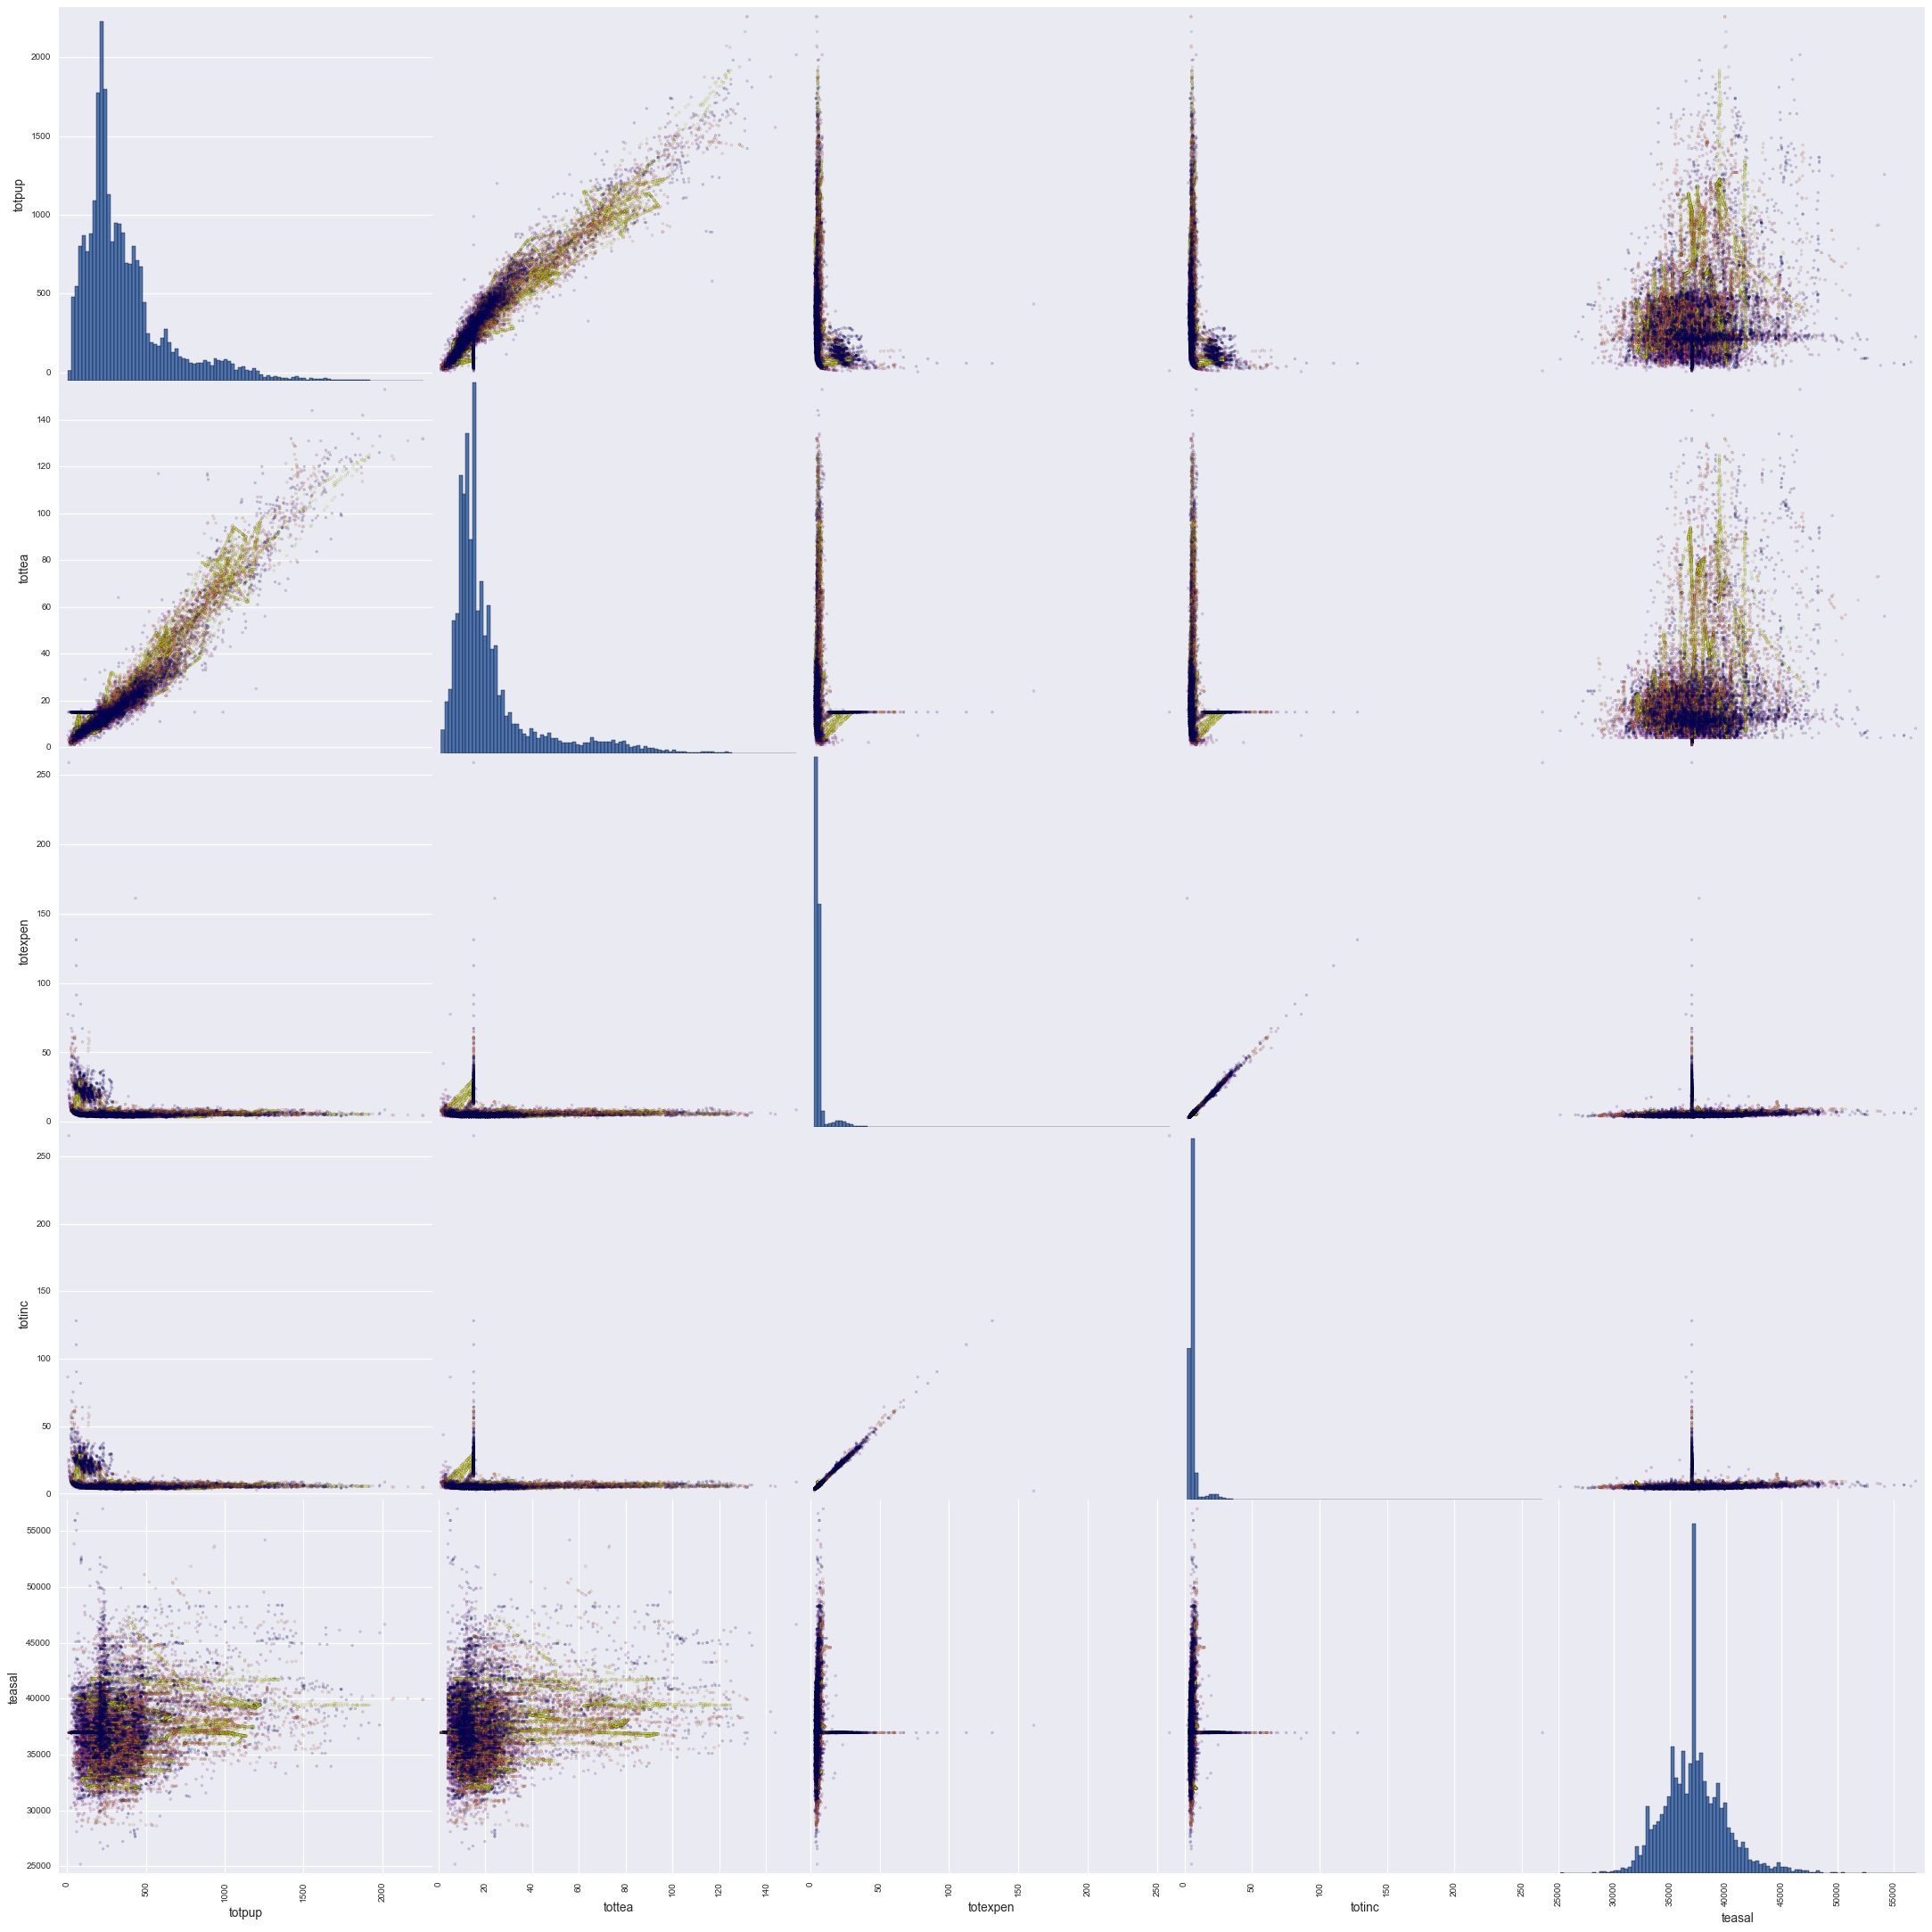

In [76]:
from pandas.tools.plotting import scatter_matrix

_ = scatter_matrix(pd.DataFrame(X_res, columns=['totpup', 'tottea', 'totexpen', 'totinc', 'teasal']), 
                   alpha=0.2, figsize=(30, 30), diagonal='hist', 
                   grid=False, c=Y_res, cmap=cm.plasma, hist_kwds={'bins':100})

### Trying out t-Distributed Stochastic Neighbor Embedding

http://lvdmaaten.github.io/tsne/

In [78]:
from sklearn import manifold

(-12, 10.0)

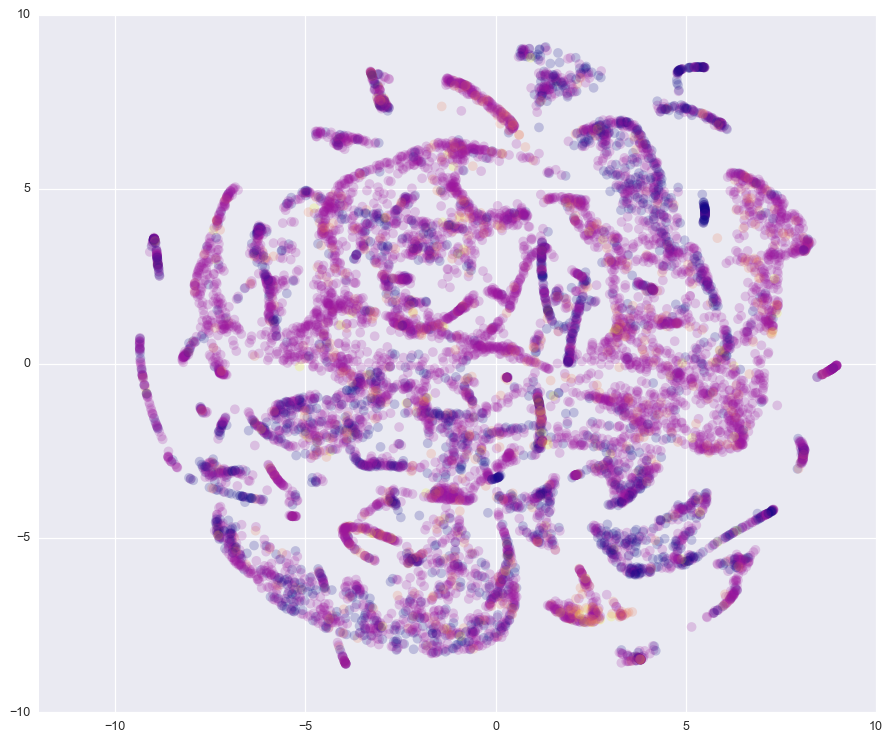

In [99]:
tsne = manifold.TSNE(n_components=2, perplexity=30.0, early_exaggeration=4.0, 
                     learning_rate=1000.0, n_iter=1000, n_iter_without_progress=30, 
                     min_grad_norm=1e-07, metric='euclidean', init='random', 
                     verbose=0, random_state=None, method='barnes_hut', angle=0.5)

X_tsne_trans = tsne.fit_transform(StandardScaler().fit_transform(X.values))

figure(figsize=(12,10))
scatter(X_tsne_trans[:,0], X_tsne_trans[:,1], marker='o', alpha=0.2, c=Y, #c=clust_labels,
        cmap=cm.plasma, linewidth='0', s=60) 
xlim(-12)

(-12, 10.0)

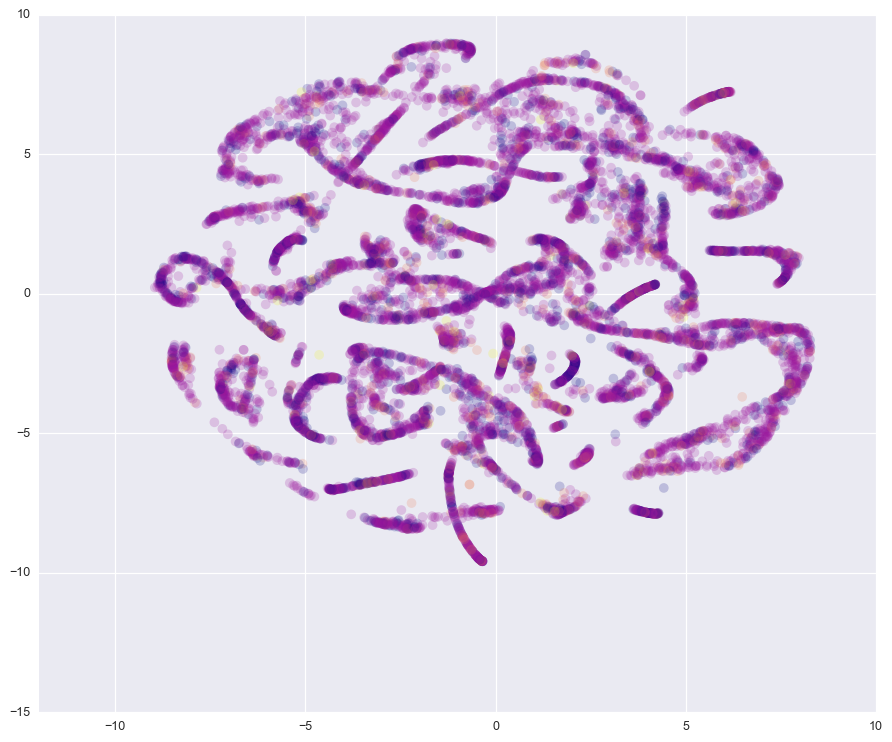

In [104]:
tsne = manifold.TSNE(n_components=2, perplexity=60.0, early_exaggeration=4.0, 
                     learning_rate=1000.0, n_iter=1000, n_iter_without_progress=30, 
                     min_grad_norm=1e-07, metric='euclidean', init='random', 
                     verbose=0, random_state=None, method='barnes_hut', angle=0.5)

X_tsne_trans = tsne.fit_transform(X.values)

figure(figsize=(12,10))
scatter(X_tsne_trans[:,0], X_tsne_trans[:,1], marker='o', alpha=0.2, c=Y, #c=clust_labels,
        cmap=cm.plasma, linewidth='0', s=60) 
xlim(-12)

(-12, 5.0)

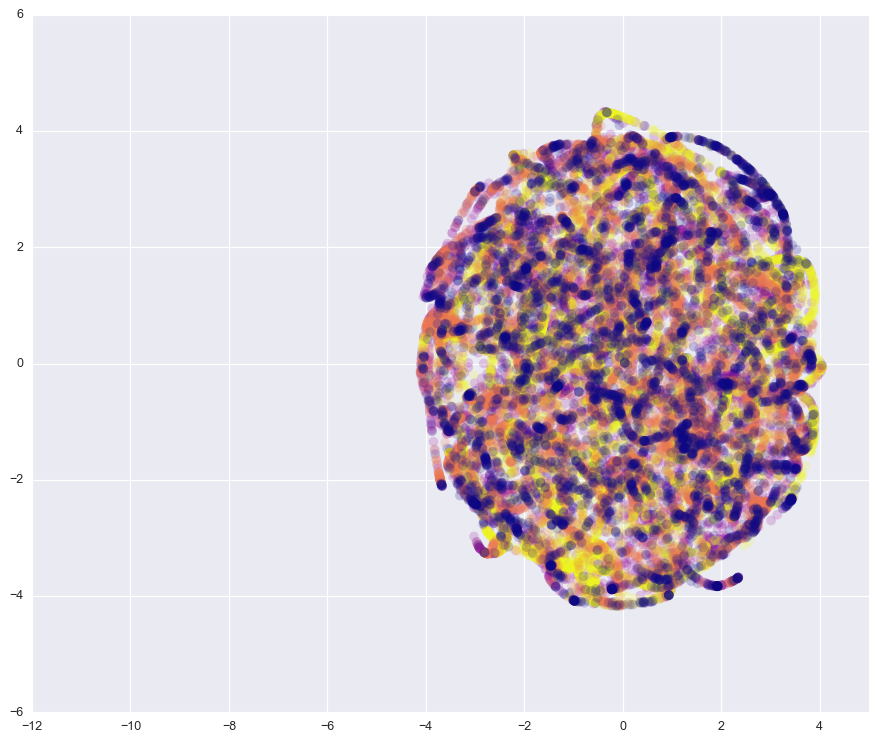

In [106]:
tsne = manifold.TSNE(n_components=2, perplexity=60.0, early_exaggeration=4.0, 
                     learning_rate=1000.0, n_iter=1000, n_iter_without_progress=30, 
                     min_grad_norm=1e-07, metric='euclidean', init='random', 
                     verbose=0, random_state=None, method='barnes_hut', angle=0.5)

X_tsne_trans = tsne.fit_transform(X_res)

figure(figsize=(12,10))
scatter(X_tsne_trans[:,0], X_tsne_trans[:,1], marker='o', alpha=0.2, c=Y_res, #c=clust_labels,
        cmap=cm.plasma, linewidth='0', s=60) 
xlim(-12)

##### Removing more outliers

In [133]:
X[['totpup', 'tottea', 'totexpen', 'totinc']].describe()

,totpup,tottea,totexpen,totinc
count,10646.000000,10646.000000,10646.000000,10646.000000
mean,326.853090,19.405035,6.230274,6.277155
std,252.470578,17.310253,5.873070,5.738859
min,4.000000,1.000000,2.838000,2.000000
25%,181.000000,10.000000,4.379000,4.439000
50%,249.000000,15.000000,4.950000,5.017000
75%,417.000000,22.000000,5.799000,5.850000
max,2260.000000,153.000000,258.685000,265.210000


In [134]:
X_subset = X[X.totinc<(X.totinc.mean() + 5*X.totinc.std())]

In [135]:
X_subset.reset_index(drop=True, inplace=True)

In [136]:
X_subset

,is__Maintained School,is__Special School,is__Primary,is__Secondary,is__Special,totpup,tottea,totexpen,totinc,teasal,preofsted
0,1,0,1,0,0,250.0,22.0,8.288,8.775,43148.00000,1.0
1,1,0,1,0,0,417.0,25.0,6.798,6.687,42507.00000,2.0
2,1,0,1,0,0,456.0,29.0,6.294,6.576,43168.00000,2.0
3,1,0,1,0,0,406.0,25.0,6.406,6.873,42396.00000,2.0
4,1,0,1,0,0,455.0,24.0,5.629,5.590,40168.00000,2.0
5,1,0,1,0,0,371.0,20.0,7.530,7.347,46942.00000,2.0
6,1,0,1,0,0,221.0,11.0,7.516,7.342,43779.00000,2.0
7,1,0,1,0,0,225.0,17.0,7.002,6.807,45892.00000,2.0
8,1,0,1,0,0,111.0,6.0,8.308,7.962,48315.00000,2.0
9,1,0,1,0,0,443.0,28.0,7.878,8.026,43636.00000,3.0
